# Fitting a GLM using glm_utils

We will follow closely the approach taken in Coen et al. (2014), where individual GLMs are fitted to different covariates.

An alternative approach - in which a single model that contains all features is fitted - is illustrated in [notebook](link)

In [1]:
import glm_utils
import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model
import sklearn.model_selection

from demo_utils import get_data
plt.style.use('ncb.mplstyle')

Generate toy data based on a model with pre-defined filters. 

The stimulus `x` - 4 features. 

The response `y` is produced by filtering each of the four stimulus features in `x` with it's respective filter and summing.

x: (10000, 4), y: (10000,), filters (50, 4)


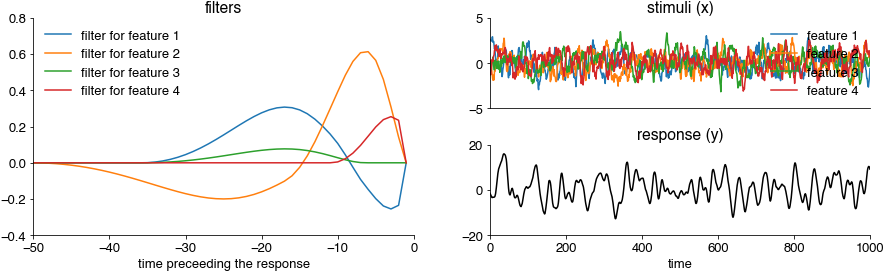

In [2]:
x, y, filters = get_data(npoints = 10_000)

npoints, ninputs = x.shape
filter_duration = filters.shape[0]
T = np.arange(-filter_duration, 0)

print(f"x: {x.shape}, y: {y.shape}, filters {filters.shape}")
plt.figure(figsize=[15,4])
plt.subplot(121)
plt.plot(T, filters)
plt.title('filters')
plt.xlabel('time preceeding the response')
plt.legend([f'filter for feature {f}' for f in range(1,5)])

plt.subplot(222)
plt.plot(x[:1000])
plt.title('stimuli (x)')
plt.legend([f'feature {f}' for f in range(1,5)])
plt.xticks(())

plt.subplot(224)
plt.plot(y[:1000], c='k')
plt.title('response (y)')
plt.xlabel('time')
plt.subplots_adjust(hspace=0.4)
plt.show()


## Time-delay-embedding and basis projection
Since we are interested in what temporal patterns in the features drive our response, we make time explicit.

Each row in `X_m` contains...

First `window_size` samples are cut sine the stimulus history for the first sample is unknown. `time_delay_embedding` ensures that `y` is still aligned with `X` after the embedding, by also cutting the first `window_size` samples from `y`. Both are therefore slightly shorter after embedding.

In [3]:
print(f'before embedding: x {x.shape}, y {y.shape}')
feature = 1
window_size = 50
X_m, y_m = glm_utils.preprocessing.time_delay_embedding(x[:, feature], y, window_size=window_size)
print(f"after embedding: X {X_m.shape}, y {y_m.shape}")

before embedding: x (10000, 4), y (10000,)
after embedding: X (9950, 50), y (9950,)


## Define a basis

To account for multiple time scales in the model, reduce the number of covariates, and implement a smoothness prior

Check `glm_utils.bases` and [wiki] for description of all bases - raised_cosine

`BasisProjection` implements sklearn's Transformer(?) API so it can be used in sklearn pipelines. Relevant functions for now: 
- `transform` - project from the to basis
- `inverse_transform` - recover from basis coefficients the time domain presentation

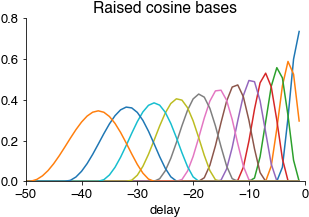

after embedding and basis projection: X (9950, 12),  y (9950,)


In [4]:
# define bases
window_size = 50
B = glm_utils.bases.raised_cosine(0, 12, [0, 36], 16, window_size)
basis_projection = glm_utils.preprocessing.BasisProjection(B)
_, nbases = B.shape
T = np.arange(-window_size, 0)

plt.figure(figsize=(5,3))
plt.plot(T, B)
plt.title('Raised cosine bases')
plt.xlabel('delay')
plt.show()

X_b = basis_projection.transform(X_m)
print(f"after embedding and basis projection: X {X_b.shape},  y {y_m.shape}")

## Split data into train and test set
Data for fitting and evaluating the model - avoid overfitting.

This is also required to test multiple models with the same data points.

In [5]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_b, y_m, test_size=0.2)
print(f"train data: {X_train.shape}, test data: {X_test.shape}")

train data: (7960, 12), test data: (1990, 12)


## Fit the model
Since `y` is a continuous variable, we use linear regression with L1 regularization (Lasso). For binary `y`, for instance the presence or absence of a spike or behavioral event, use `LogisticRegressionCV`.

In [6]:
lr = sklearn.linear_model.LassoCV(max_iter=10_000)
lr.fit(X_train, y_train)
print(f'test score (r2): {lr.score(X_test, y_test):1.2f}')

test score (r2): 0.65


## Reconstruct the filter from the model coefficients

filter norm: 1.66


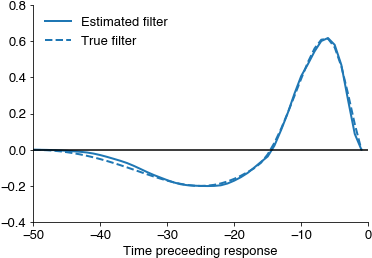

In [7]:
basis_weights = lr.coef_
filter_shape = basis_projection.inverse_transform(basis_weights)
print(f'filter norm: {np.linalg.norm(filter_shape):1.2f}')
plt.plot(T, filter_shape.T, linewidth=2, markersize=10, label='Estimated filter')
plt.gca().set_prop_cycle(None)
plt.plot(T, filters[:, feature], '--', linewidth=2, label='True filter')
plt.axhline(c='k')
plt.xlabel('Time preceeding response')
plt.yticks(np.arange(-0.4, 1.0, 0.4))
plt.legend()
plt.show()

## Run the pipeline for independent train-test splits to obtain error bars on the filters and scores
This can take a minute or so...

In [8]:
nb_splits = 100
nb_features = x.shape[1]

filter_shapes = np.zeros((nb_features, nb_splits, window_size))
filter_norms = np.zeros((nb_features, nb_splits))
test_scores = np.zeros((nb_features, nb_splits))

# initialize the lasso regression object
lr = sklearn.linear_model.LassoCV(max_iter=10_000)  # increase max_iter to ensure convergence

# loop through all features
for feat in range(nb_features):
    Xs, ys = glm_utils.preprocessing.time_delay_embedding(x[:, feat], y, window_size=window_size, flatten_inside_window=True)
    Xs_b = basis_projection.transform(Xs)
    
    for split in range(nb_splits):
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(Xs_b, ys, test_size=0.5)
        lr.fit(X_train, y_train)

        # eval model and reconstruct filters
        basis_weights = lr.coef_
        filter_shape = basis_projection.inverse_transform(basis_weights)
        filter_shapes[feat, split, :] = filter_shape
        filter_norms[feat, split] = np.linalg.norm(filter_shape)
        test_scores[feat, split] = lr.score(X_test, y_test)

KeyboardInterrupt: 

Features can be ranked by the scores. (sqrt(r2)) or - if the each feature is normalized - the filter norm.

Solid line average over the filters obtained from each split (thin lines). Dashed line - true filters.

In [9]:
feature_names = [f'Feature {ii}' for ii in range(ninputs)]
feature_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=[8,8])
plt.subplot(221)
for feat in range(nb_features):
    plt.plot(filter_norms[feat], [feat]*nb_splits, 'ok', alpha=0.5)
    plt.barh(feat, np.mean(filter_norms[feat]))
    plt.text(np.mean(filter_norms[feat]) + 0.05, feat+0.15, s=f"$r^2$={np.mean(test_scores[feat]):0.2f}")
plt.yticks(np.arange(nb_features), feature_names)
plt.xlabel('Filter norm')
plt.xlim(0)
plt.subplot(222)
for feat in range(nb_features):
    plt.plot(np.sqrt(test_scores[feat]), [feat]*nb_splits, 'ok', alpha=0.5)
    plt.barh(feat, np.mean(np.sqrt(test_scores[feat])))
plt.yticks(())
plt.xlabel('$\sqrt{Test score}$ (r)')
plt.xlim(0)

plt.subplot(212)
for feat in range(nb_features):
    plt.plot(T, filter_shapes[feat,...].T, linewidth=1, alpha=0.1, color=feature_colors[feat])

plt.gca().set_prop_cycle(None)
plt.plot(T, np.mean(filter_shapes, axis=1).T, linewidth=2, label='Estimated filter')

plt.gca().set_prop_cycle(None)
plt.plot(T, filters, '--', linewidth=2, label='True filter')
plt.axhline(0, color='k')
plt.xlabel('Time preceeding response')
plt.yticks(np.arange(-0.4, 1.0, 0.4))
plt.legend(loc='upper left')
plt.show()

NameError: name 'ninputs' is not defined